<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
!pip install timm
!pip install tqdm
!pip install kora

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.3 MB/s eta 0:00:00


In [2]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import random
import re
import json
import timm
import gdown
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from google.colab import widgets

from tqdm.asyncio import tqdm
from kora.xattr import get_id
import asyncio
import aiohttp
import nest_asyncio
nest_asyncio.apply()
loop = asyncio.get_event_loop()

## 存取

In [3]:
def get_data_disk(driveroot, targetdir):
  """從雲端資料夾targetdir下載檔案到colab root底下同名資料夾
  只下載沒有下載的檔案.

  driveroot為雲端檔案資料夾root"""

  if not os.path.exists('/content/' + targetdir):
    os.makedirs(targetdir)
    print(f"making {targetdir} dir...")

  files_on_drive = os.listdir(driveroot+'/'+targetdir)
  files_in_localdir = os.listdir(f"/content/{targetdir}")
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(f'{driveroot}/{targetdir}/{filename}')) for filename in files_to_download]


  for idx, (name, file_id) in enumerate(files):

    if not file_id:
      print(f"未找到文件: {name}")
      continue

    # 下载文件
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
      status, done = downloader.next_chunk()
      # print(f"下载 {name} 进度: {int(status.progress() * 100)}%")

    # 将文件内容写入本地文件
    local_file_path = os.path.join('/content', targetdir, name)

    with open(local_file_path, 'wb') as f:
      fh.seek(0)
      f.write(fh.read())

    print(f"{idx+1}/{len(files)}: {name} downloaded")




async def download_file(session, name, file_id, file_path, token):
  if not file_id:
    print(f"未找到文件: {name}")
    return

  download_url = f"https://www.googleapis.com/drive/v3/files/{file_id}?alt=media"
  headers = {"Authorization": f"Bearer {token}"}

  async with session.get(download_url, headers=headers) as response:
    if response.status == 200:
      with open(file_path, 'wb') as f:
        while True:
          chunk = await response.content.read(1024)
          if not chunk:
            break
          f.write(chunk)
      # print(f"Downloaded: {name}...")
    else:
      print(f"Failed: {name}!! status: {response.status}")


# 定义异步获取数据的主函数
async def get_data_disk_async(driveroot, targetdir, token):
  # 生成文件夹的绝对路径
  drive_folder_path = os.path.join(driveroot, targetdir)
  local_folder_path = os.path.join('/content', targetdir)

  if not os.path.exists(local_folder_path):
    os.makedirs(local_folder_path)
    print(f"making {targetdir} dir...")

  # 获取文件列表
  files_on_drive = os.listdir(drive_folder_path)
  files_in_localdir = os.listdir(local_folder_path)
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(os.path.join(drive_folder_path, filename))) for filename in files_to_download]

  async with aiohttp.ClientSession() as session:
    tasks = []
    for idx, (name, file_id) in enumerate(files):
      local_file_path = os.path.join(local_folder_path, name)
      task = asyncio.create_task(download_file(session, name, file_id, local_file_path, token))
      tasks.append(task)

    # 使用 tqdm 包装任务列表以显示进度条
    for f in tqdm.as_completed(tasks, total=len(tasks)):
      await f



def process_data2(traindir, shift=0, termi=10, dropFalse=0.85, dropPos=0, files=None):
  """Reading data in "traindir" and process them.
  Taking care of memory efficiency"

  Args:
    shift: 從第幾個開始讀取 (當files給定時無效)
    termi: 讀取幾個 (當files給定時無效)
    dropFalse: 被刪除的有闌尾炎的張數比例
    dropPos: 被刪除的有闌尾炎的張數比例
    files: 要讀取的檔案id，預設是None

  Returns:
    images: 输出的图像数据
    labels: 输出的标签数据
  """

  if not files:
    filelist = os.listdir(traindir)
    filelist = filelist[shift:shift+termi]
  else: filelist = files

  return loading_data(traindir, filelist, dropFalse, dropPos)



def loading_data(traindir, filelist, dropFalse, dropPos)\
 -> tuple[torch.tensor, torch.tensor]:

  print(f"reading {traindir=}...")
  labels_ = read_label(labelpath)

  if labels_.index.name != 'id':
    labels_.set_index('id', inplace=True)

  #裁減過的圖片放在Cropped_[範圍]的資料夾下,用路徑名稱判斷資料使否裁減過
  cropmatch = re.search(r'Cropped', traindir)
  if not cropmatch:
    print("讀取未切片的資料夾")
    xlim, ylim, zlim = [0,512], [0,512], [0,None]
  else:
    #範圍 = xstart-xend_ystart-yend_zstart-zend
    ismatch = re.search(r'(\d+-\d+)_(\d+-\d+)_(\d+-\d+)', traindir)
    if ismatch:
      dimens = ismatch.group(0)
      labelidx = dimens.split('_')
      xlim = [int(idx) for idx in labelidx[0].split('-')]
      ylim = [int(idx) for idx in labelidx[1].split('-')]
      zlim = [int(idx) for idx in labelidx[2].split('-')]
      print(f"{xlim=}\n{ylim=}\n{zlim=}")
      if xlim[0] >= xlim[1] or ylim[0] >= ylim[1] or zlim[0] >= zlim[1]:
        print("切片格式不正确")
        return
    else:
      print("切片格式不正确")
      return



  # preallocated(有無裁減過影響preallocated的大小)
  if not cropmatch:
    selecteds = [labels_.loc[labels_.index.str.startswith(afile.strip('.nii.gz')+'_')] for afile in filelist]
    numcuts = [len(selected) for selected in selecteds]
    numcuts = sum(numcuts)
  else:
    numcuts = (zlim[1]-zlim[0]) * len(filelist)
  images = torch.zeros(numcuts,1, ylim[-1]-ylim[0],xlim[-1]-xlim[0])
  labels = -torch.ones(numcuts)
  nimgs = 0
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(traindir, key)
    key = key.strip('.nii.gz')
    scan  = labels_.loc[labels_.index.str.startswith(key+'_')]
    value = nib.load(file_path).get_fdata()

    label_t = torch.tensor(scan['label'][zlim[0]:zlim[-1]]) #每個scan只拿zlim範圍，不滿60張的拿完
    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    #有幾筆不是512x512, 剪成512x512
    if (not cropmatch) and (image_t.shape[2] != 512 or image_t.shape[3] != 512):
      image_t = cropping(image_t)

    image_t, label_t = remove_false_images(image_t, label_t, dropFalse)
    image_t, label_t = remove_positive_images(image_t, label_t, dropPos)

    n_new = len(label_t)

    images[nimgs:nimgs+n_new] = image_t
    labels[nimgs:nimgs+n_new] = label_t
    nimgs += len(label_t)
    print(f"Process {nprocess}: {key} finished...")
    nprocess += 1


  #after drop
  counts = count_zero(images)
  images = torch.asarray(images[:len(images)-counts])
  labels = labels[labels != -1]

  return images, labels.float()




def read_test(testdir,shift=0,termi=10):
  """Reading data in "testdir"
  not memory efficient
  Args:
    shift: 從第幾個開始讀取
    termi: 讀取幾個
  Returns:
    images: 输出的图像数据
    scans_info: 每個scan的檔名和切片數(原本nii檔所包含的數量)

  """


  filelist = os.listdir(testdir)
  filelist = filelist[shift:shift+termi]
  scans_info = []

  images = []
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(testdir, key)
    key = key.strip('.nii.gz')
    value = nib.load(file_path).get_fdata()
    scans_info.append((key, value.shape[2]))

    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    images.append(image_t)
    print(f"{nprocess}: Read test {key} finished...")
    nprocess += 1

  images = torch.cat(images,dim=0)
  print(f"read {len(scans_info)} scans")

  return images, scans_info




def save_model(model, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):

  if not model:
    print("not given model")
    return

  if not os.path.exists(root):
    print(f"{root} not exists!")
    return

  print(f"model will be saved as {root}/{dirname}/{modelname}")

  if not modelname:
    modelname = input("請輸入模型儲存的檔名:")
  if not dirname:
    dirname = input("請輸入模型儲存的資料夾:")

  filename = f"{root}/{dirname}/{modelname}"

  if not os.path.exists(os.path.dirname(filename)):
    os.mkdir(os.path.dirname(filename))

  if os.path.isfile(filename+'.pth'):
      print(f"{filename}.pth exist.")
  else:  #Adam的方向也要存放
      torch.save({'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, f'{filename}.pth')

  return filename



def load_model(_model, opti=None, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):
  """加載模型參數與優化器，如果沒給優化器，則返回None
   如果沒找到訓練參數, 則返回None
   如果沒給資料夾名稱，則產生input prompt請user輸入
    return model, opti, params
  """
  if not modelname:
    modelname = input("請輸入模型參數檔案名稱:")
  if not dirname:
    dirname = input("請輸入儲存模型的母資料夾名稱:")

  filename = f"{root}/{dirname}/{modelname}"
  checkpoint = torch.load(filename+'.pth')
  _params = None


  print(_model.load_state_dict(checkpoint['model_state_dict']))

  if os.path.isfile(filename+'.json'):
    with open(f'{filename}.json', 'r') as f:
      _params = json.load(f)
  if opti:
    opti.load_state_dict(checkpoint['optimizer_state_dict'])

  return _model,opti,_params, filename






def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df


def read_split(excel_path):
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    return df

def write_error(logpath, e, nprocess):
  # with open(logpath, 'a') as f:
    # f.write(f"{nprocess:} error occured: {e}\n") ##! may stuck the program!!
  print(f"{nprocess:} error occured: {e}\n")


def read_submission(excel_path) -> pd.DataFrame:
  """Reads a csv file containing submission file.
    The csv file should follow the format given by Kaggle.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df




## 列印結果

In [4]:
def get_confusion(guess, truth):
  if torch.is_tensor(guess):
    guess = guess.cpu().numpy()
  if torch.is_tensor(truth):
    truth = truth.cpu().numpy()

  right = guess == truth
  wrong = np.logical_not(right)
  TP = np.sum(np.logical_and(right, truth == np.ones(right.shape)))
  TN = np.sum(np.logical_and(right, truth == np.zeros(right.shape)))
  FN = np.sum(np.logical_and(wrong, truth == np.ones(wrong.shape)))
  FP = np.sum(np.logical_and(wrong, truth == np.zeros(wrong.shape)))
  return (TP,FP,FN,TN)


def get_score(TP,FP,FN,TN):
  recall = TP/(TP + FN)
  precision = TP/(TP + FP)
  recall = 0 if np.isnan(recall) else recall.item()
  precision = 0 if np.isnan(precision) else precision.item()
  F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

  return recall, precision, F1


def print_results(prediction, labels_):
  TP,FP,FN,TN = get_confusion(prediction, labels_)
  recall, precision, F1 = get_score(TP,FP,FN,TN)
  print(f"\n\
      真實值\n\
  預  +-----+-----+\n\
  測| TP: {TP}| FP: {FP}|\n\
  值| FN: {FN}| TN: {TN}|\n\
      +-----+-----+ \n")

  print(f"{recall=}\n{precision=}\n{F1=}\n")

def create_tab(tabnames):
  tb = widgets.TabBar(tabnames)
  return tb


def display_train(train_info, predict_info_valid, predict_info_train):
  t_loss, t_accu, v_loss, v_accu = train_info
  predict_list_v, labels_v = predict_info_valid
  TP_v,FP_v,FN_v,TN_v = get_confusion(predict_list_v, labels_v)
  recall_v, precision_v, F1_v = get_score(TP_v,FP_v,FN_v,TN_v)

  predict_list_t, labels_t = predict_info_train
  TP_t,FP_t,FN_t,TN_t = get_confusion(predict_list_t, labels_t)
  recall_t, precision_t, F1_t = get_score(TP_t,FP_t,FN_t,TN_t)

  msg = [f"Epoch  train_loss  train_accu   valid_loss  valid_accu",
    f"(valid)recall      precision    F1",
    f"(train)recall      precision    F1"]

  print('-'*len(msg[0]))
  print(msg[0])
  print(f"{epoch:>5d}: {t_loss:<10.8f}  {t_accu:<10.8f}%  {v_loss:<10.8f}  {v_accu:<10.8f}%")
  print(msg[1])
  print(f"       {recall_v:<6.8f}  {precision_v:<11.8f}  {F1_v:<.8f}")
  print(f"       {TP_v=}  {FP_v=}  {FN_v=}  {TN_v=}")
  print(msg[2])
  print(f"       {recall_t:<6.8f}  {precision_t:<11.8f}  {F1_t:<.8f}")
  print(f"       {TP_t=}  {FP_t=}  {FN_t=}  {TN_t=}")
  print('-'*len(msg[0]))

## 數據裁減




In [5]:
def argumenting(images, labels, n=5):
  """
  數據增強。
  在images裡面把所有有闌尾炎的cut複製給定次數，並
  插入回images的隨機位置裡面

  Args:
    images: 输入的图像数据
    labels: 输入的标签数据
    n: 每个样本複製多少次

  Returns:
    增強后的图像数据和标签数据
  """
  where = (labels == True).nonzero(as_tuple=True)[0]
  bad_images = images[where]

  rep_imgs = bad_images.repeat(n, 1, 1, 1)
  rep_labels = torch.ones(rep_imgs.shape[0], dtype=labels.dtype)

  # import pdb
  # pdb.set_trace()
  # 隨機插入argumented圖片
  nimg = images.shape[0]
  rnd_pos = torch.randint(0, nimg, (rep_imgs.shape[0],))
  images = torch.cat((images, rep_imgs), dim=0)
  images = images[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  # 對應對置插入標籤
  labels = torch.cat((labels, rep_labels), dim=0)
  labels = labels[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  return images, labels

def remove_false_images(images, labels, ratio):
    """
    隨機在images裡面移除一定比例的無闌尾炎cut

    Args:
      images: 输入的图像数据
      labels: 输入的标签数据
      ratio: 移除的比例

    Returns:
      移除后的图像数据和标签数据
    """
    # 找出 labels == 0 的索引
    where_false = (labels == 0).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_false))[:int(len(where_false)*ratio)]
    mask[where_false[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels

def remove_positive_images(images, labels, ratio):
    # 找出 labels == 1 的索引
    where_positive = (labels == 1).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_positive))[:int(len(where_positive)*ratio)]
    mask[where_positive[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels


def k_fold_split_indices(num_samples, k=5,shuffle_=True):
  """返回geneartor for index. 省記憶體"""
  state_ = None
  if shuffle_:
    state_ = 42
  kf = KFold(n_splits=k, shuffle=shuffle_, random_state=state_)
  return ((train_index, test_index) for train_index, test_index in kf.split(range(num_samples)))


splitpath = r"/content/drive/MyDrive/AOCR2024/TrainValid_split.csv"
def get_split(splitpath=splitpath):
  dfsplit = read_split(splitpath)
  train_ids,valid_ids = (dfsplit[dfsplit['group']=='Train'])['id'].tolist(),(dfsplit[dfsplit['group']=='Valid'])['id'].tolist()
  train_ids,valid_ids = [train_id +'.nii.gz' for train_id in train_ids], [valid_id +'.nii.gz' for valid_id in valid_ids]
  return train_ids,valid_ids

## 數據處理

## 其他

In [6]:

def count_zero(images):
  count = 0
  for image in images:
    if not torch.any(image):
      count += 1
  return count

def cropping(image):
  if image.shape[2] != 512:
    start = (image.shape[2] - 512) // 2
    end = start + 512
    image = image[:, :, start:end, :]

  if image.shape[3] != 512:
    start = (image.shape[3] - 512) // 2
    end = start + 512
    image = image[:, :, :, start:end]
  return image




def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面


def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        # raise("GPU not available")
    return device


In [7]:
device = isgpu()

GPU is available


# 掛載


In [8]:
from google.colab import drive
drive.mount('/content/drive/',)

Mounted at /content/drive/


In [9]:
cd /content/

/content


In [10]:
!pwd

/content


In [11]:
drive_rootdir = "/content/drive/MyDrive/AOCR2024"
labelpath = '/content/drive/MyDrive/AOCR2024/TrainValidTest_ground_truth.csv'
# datadir ="Train_Valid_Image"
datadir ="Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped"


Use service account to access googledrive

In [12]:
from google.oauth2 import service_account
import googleapiclient.discovery

# 左側Secret存有private key
from google.colab import userdata
private_key = userdata.get('private_key')
private_key_id = userdata.get('private_key_id')

credentials_info = {
    "type": "service_account",
    "project_id": "appendicitis-407217",
    "private_key_id": private_key_id,
    "private_key": private_key,
    "client_email": "appendix@appendicitis-407217.iam.gserviceaccount.com",
    "client_id": "106423688397478405739",
    "auth_uri": "https://accounts.google.com/o/oauth2/auth",
    "token_uri": "https://oauth2.googleapis.com/token",
    "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
    "client_x509_cert_url": "https://www.googleapis.com/robot/v1/metadata/x509/appendix%40appendicitis-407217.iam.gserviceaccount.com"
}

credentials = service_account.Credentials.from_service_account_info(
    credentials_info,
    scopes=["https://www.googleapis.com/auth/drive"]
)

# 使用凭证创建Google Drive服务实例
service = googleapiclient.discovery.build('drive', 'v3', credentials=credentials)

# 資料下載(非同步)

In [13]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, datadir,token = credentials.token))

making Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped dir...


100%|██████████| 1000/1000 [00:38<00:00, 25.76it/s]


In [14]:
!curl ipecho.net/plain

34.143.249.64

In [15]:
len(os.listdir(datadir))

1000

## 下載測試資料


In [22]:
testdir = "Cropped_60-316_150-406_11-71/Test_Image_cropped"
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, testdir,token = credentials.token))


0it [00:00, ?it/s]


In [23]:
len(os.listdir(testdir))

200

# Dataset/Model

In [24]:
import copy

class CustomDataset(Dataset):
    def __init__(self, images, labels, mode='train', transform=None):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image = self.images[idx]
      if self.transform:
        image = self.transform(self.images[idx])

      if self.mode in ['train', 'valid']:
          return image, self.labels[idx]
      elif self.mode == 'test':
          return image

## helper

In [25]:
def train(loader, model_, optimizer, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.train()
  running_loss = 0.0
  correct_count = 0
  total_count = 0
  predict_list_ = torch.tensor(()).to(device)
  labels_ = torch.tensor(()).to(device)

  for batch_images, batch_labels in loader:
      batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
      optimizer.zero_grad()
      outputs = model_(batch_images).squeeze()
      predicted_t = (outputs > threshold).int()
      loss = criterion(outputs, batch_labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      total_count += batch_labels.size(0)
      correct_count += (predicted_t == batch_labels).sum().item()
      predict_list_ = torch.concat((predict_list_, predicted_t), 0)
      labels_ = torch.concat((labels_, batch_labels), 0)


  epoch_loss = running_loss / len(loader)
  epoch_accuracy = 100 * correct_count / total_count

  return epoch_loss, epoch_accuracy, predict_list_, labels_



def valid(loader, model_, criterion, threshold, device):
  """模型輸出值超過threshold當作陽性"""
  model_.eval()
  testing_loss = 0.0
  correct = 0
  total = 0
  predict_list_ = torch.tensor(()).to(device)
  labels_ = torch.tensor(()).to(device)

  with torch.no_grad():
      for i, (batch_images, batch_labels) in enumerate(loader):
          batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
          outputs = model_(batch_images).squeeze()
          predicted_v = (outputs > threshold).int()
          loss = criterion(outputs, batch_labels)

          testing_loss += loss.item() #單個batch平均loss
          bsize = batch_labels.size(0)
          total += bsize
          correct += (predicted_v == batch_labels).sum().item()
          predict_list_ = torch.concat((predict_list_, predicted_v), 0)
          labels_ = torch.concat((labels_, batch_labels), 0)

  valid_loss = testing_loss / len(loader) #單個epoch平均loss
  valid_accuracy = 100 * correct / total

  return valid_loss, valid_accuracy, predict_list_, labels_




In [26]:
class ModelError(Exception):
    def __init__(self, message):
        super().__init__(message)

In [52]:
del model_name

# Unet(with/without) decoder

In [67]:
model_name_temp = "unet_without_decoder"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError('已經初始化其他model了')
else:
  model_name = model_name_temp


# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet, self).__init__()
#         self.inc = DoubleConv(in_channels, 64)
#         self.down1 = DoubleConv(64, 128)
#         self.down2 = DoubleConv(128, 256)
#         self.down3 = DoubleConv(256, 512)
#         self.down4 = DoubleConv(512, 512)
#         self.up1 = DoubleConv(1024, 256)
#         self.up2 = DoubleConv(512, 128)
#         self.up3 = DoubleConv(256, 64)
#         self.up4 = DoubleConv(128, 64)
#         self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
#         self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(nn.MaxPool2d(2)(x1))
#         x3 = self.down2(nn.MaxPool2d(2)(x2))
#         x4 = self.down3(nn.MaxPool2d(2)(x3))
#         x5 = self.down4(nn.MaxPool2d(2)(x4))
#         x = self.up1(torch.cat([nn.Upsample(scale_factor=2)(x5), x4], dim=1))
#         x = self.up2(torch.cat([nn.Upsample(scale_factor=2)(x), x3], dim=1))
#         x = self.up3(torch.cat([nn.Upsample(scale_factor=2)(x), x2], dim=1))
#         x = self.up4(torch.cat([nn.Upsample(scale_factor=2)(x), x1], dim=1))
#         x = self.outc(x)
#         x = self.avgpool(x)  # 应用全局平均池化
#         x = torch.flatten(x, 1)  # 展平
#         x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
#         return x


## 沒有decoder的
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.down4 = DoubleConv(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
        self.fc = nn.Linear(512, out_channels)  # 添加全连接层
        self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(nn.MaxPool2d(2)(x))
        x = self.down2(nn.MaxPool2d(2)(x))
        x = self.down3(nn.MaxPool2d(2)(x))
        x = self.down4(nn.MaxPool2d(2)(x))

        x = self.avgpool(x)  # 应用全局平均池化
        x = torch.flatten(x, 1)  # 展平
        x = self.fc(x)  # 应用全连接层
        x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
        return x

# 创建 U-Net 模型实例
unet_model = UNet(in_channels=1, out_channels=1)

# 三層Unet(with/without) decoder

In [53]:
model_name_temp = "unet_without_decoder"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError('已經初始化其他model了')
else:
  model_name = model_name_temp


# class UNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNet, self).__init__()
#         self.inc = DoubleConv(in_channels, 64)
#         self.down1 = DoubleConv(64, 128)
#         self.down2 = DoubleConv(128, 256)
#         self.down3 = DoubleConv(256, 512)
#         self.down4 = DoubleConv(512, 512)
#         self.up1 = DoubleConv(1024, 256)
#         self.up2 = DoubleConv(512, 128)
#         self.up3 = DoubleConv(256, 64)
#         self.up4 = DoubleConv(128, 64)
#         self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
#         self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(nn.MaxPool2d(2)(x1))
#         x3 = self.down2(nn.MaxPool2d(2)(x2))
#         x4 = self.down3(nn.MaxPool2d(2)(x3))
#         x5 = self.down4(nn.MaxPool2d(2)(x4))
#         x = self.up1(torch.cat([nn.Upsample(scale_factor=2)(x5), x4], dim=1))
#         x = self.up2(torch.cat([nn.Upsample(scale_factor=2)(x), x3], dim=1))
#         x = self.up3(torch.cat([nn.Upsample(scale_factor=2)(x), x2], dim=1))
#         x = self.up4(torch.cat([nn.Upsample(scale_factor=2)(x), x1], dim=1))
#         x = self.outc(x)
#         x = self.avgpool(x)  # 应用全局平均池化
#         x = torch.flatten(x, 1)  # 展平
#         x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
#         return x


## 沒有decoder的
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=5, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=5, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 512)
        # self.down3 = DoubleConv(256, 512)
        # self.down4 = DoubleConv(512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(1)  # 添加全局平均池化层
        self.fc = nn.Linear(512, out_channels)  # 添加全连接层
        self.sigmoid = nn.Sigmoid()  # 添加 Sigmoid 激活函数

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(nn.MaxPool2d(2)(x))
        x = self.down2(nn.MaxPool2d(2)(x))
        # x = self.down3(nn.MaxPool2d(2)(x))
        # x = self.down4(nn.MaxPool2d(2)(x))

        x = self.avgpool(x)  # 应用全局平均池化
        x = torch.flatten(x, 1)  # 展平
        x = self.fc(x)  # 应用全连接层
        x = self.sigmoid(x)  # 应用 Sigmoid 激活函数
        return x

# 创建 U-Net 模型实例
unet_model = UNet(in_channels=1, out_channels=1)

# EfficiencyNetV2_s


In [28]:
model_name_temp = "tf_efficientnetv2_s"

if 'model_name' in globals():
  if (model_name != model_name_temp):
    raise ModelError(f'已經初始化其他model了： {model_name}')
else:
  model_name = model_name_temp


pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# # 修改 global_pool 層
# if hasattr(pretrained_model, 'global_pool'):
#     # 使用 AdaptiveMaxPool2d 替代 SelectAdaptivePool2d
#     pretrained_model.global_pool = nn.Sequential(
#         nn.AdaptiveMaxPool2d(1),
#         nn.Flatten(start_dim=1, end_dim=-1)
#     )
# else:
#     raise AttributeError("Global pooling layer not found in the model")

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)


# 檢查模型結構
print(pretrained_model)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Sequential(
  (0): EfficientNet(
    (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
   

In [54]:
del model_name

# 資料處理

## 二八切割

In [29]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = process_data2(datadir, dropFalse=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [21]:
print(images_valid.shape)
print(len(labels_valid))

print(images.shape)
print(len(labels))

torch.Size([12000, 1, 256, 256])
12000
torch.Size([47968, 1, 256, 256])
47968


## 不割

In [ ]:
dflabel = read_label(labelpath)
total_nii = len(os.listdir(datadir))
images, labels =  process_data2(traindir=datadir, termi=10,shift=0,dropFalse=0,dropPos=0)

valid當training

In [ ]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images, labels = images_valid, labels_valid

check

In [ ]:
images_train, labels_train = remove_false_images(images, labels, 0.90)
print(images_train.shape)
print(len(labels_train))
print(images.shape)


## k-fold

In [ ]:
import gc
folds_indices = k_fold_split_indices(len(images), k=5, shuffle_=True)
# 使用生成的索引
for idx, (train_index, test_index) in enumerate(folds_indices):

  train_images, test_images = images[train_index], images[test_index]
  train_labels, test_labels = labels[train_index], labels[test_index]
  print(f"Fold {idx}: 训练集大小 {train_index}, 测试集大小 {test_index}")
  del train_images, test_images, train_labels, test_labels
  gc.collect()
#

In [ ]:
# len(labels_train)

In [ ]:
#  %reset_selective images_train, labels_train

In [ ]:
# %reset

## 處理測試資料，合併到訓練集裡面

In [42]:
images_fortrain, labels_fortrain = process_data2(testdir, shift=0, termi=200, dropFalse=0, dropPos=0)

reading traindir='Cropped_60-316_150-406_11-71/Test_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx8E3B91ED97D86D1072C6EA9220FD29DAFB96CD6BB8DC6850 finished...
Process 1: Zx2982812805D4A3FA5078DB705FF20793142A1A712F5108B5 finished...
Process 2: ZxD3CB0C4524F67A4D47F1690790F72DB31FECE3ECCB2B6B08 finished...
Process 3: Zx61704E649960C4025BB3AA0B31C1A75C71442BF48DAC3E19 finished...
Process 4: ZxE1BDE57D85B29E6B1FF4B9DB4EE825804A67EF6AAB90BCCE finished...
Process 5: ZxCC42A7155619FA3703EAF742893B8B292D91D0D647A15B0A finished...
Process 6: Zx577646F814CED80AB3D413794C12892EEB3B60D14B6215C6 finished...
Process 7: ZxA1ABBC6166B65AC2A7937A2159F61BA67D2DA16F3ED4D0FB finished...
Process 8: ZxE7E2340E9CF9166BA3E027E0C1D7FC58A90E1BE3552A780A finished...
Process 9: Zx3AB91ED4F2F9AA3B238DDC9EEE0BF3E122BE00BCE2D2CD99 finished...
Process 10: Zx00FE1B9A88E88C71917ECC1EDD774252C072CA5FDB12C01B finished...
Process 11: Zx55393C140B1339C1BC5F7EE2C28DB481D9BC6ECF9EF814ED finishe

In [43]:
print(images_fortrain.shape)
print(labels_fortrain.shape)

torch.Size([12000, 1, 256, 256])
torch.Size([12000])


In [24]:
labels = torch.concat((labels, labels_fortrain), 0)
images = torch.concat((images, images_fortrain), 0)

In [44]:
images = images_fortrain
labels = labels_fortrain

## 標準化

為了方便, 只用training set的數據計算平均值與標準差, 並套用在所用數據集的標準化中

In [30]:
mean, std = torch.mean(images), torch.std(images)
transform_standard = transforms.Normalize(mean=mean, std=std)

# 訓練

## 初始化 for first run

In [26]:
# model = pretrained_model
model = unet_model
print(model_name)

unet_without_decoder


In [49]:
model = model.to(device)
num_epochs =200
batch_size = 128
lr = 0.01
droprate = 0
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Define the learning rate scheduler
# You'll need to choose appropriate values for T_0 and T_mult
# T_0 = 10  # Example value
# T_mult = 2  # Example value
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)


print(model)

start = 0

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(

In [50]:
images_train, labels_train = remove_false_images(images, labels, droprate)
# train_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
train_dataset = CustomDataset(images_train, labels_train, transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

valid_dataset = CustomDataset(images_valid, labels_valid, transform=None)
# valid_dataset = CustomDataset(images_valid, labels_valid, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## 初始化 for not first run

In [72]:
# model = pretrained_model
model = unet_model
print(model_name)


unet_without_decoder


In [73]:
model = model.to(device)
num_epochs = 100
lr = 0.01
droprate = 0.8
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
model, optimizer, params, filename = load_model(model, optimizer)

# # Define the learning rate scheduler
# # You'll need to choose appropriate values for T_0 and T_mult
# T_0 = 10  # Example value
# T_mult = 2  # Example value
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)
start = int(filename.split('_')[-1]) + 1

print(model_name)

請輸入模型參數檔案名稱:unet_without_decoder_20
請輸入儲存模型的母資料夾名稱:unet_0.8_onlytrain
<All keys matched successfully>
batch_size:128
128
unet_without_decoder


In [ ]:
print(model_name)

In [ ]:
images_train, labels_train = remove_false_images(images, labels, droprate)

train_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

valid_dataset = CustomDataset(images_valid, labels_valid, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## 訓練

In [ ]:
modeldirname = input("dirname: ")


running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []



tabnames = [f"{epoch*10}~{epoch*10+9}" for epoch in range(num_epochs//10)]
tab = create_tab(tabnames)

for epoch in range(start, num_epochs):

    epoch_loss, epoch_accuracy, predict_list_train, labels_train_display = train(train_loader, model, optimizer, criterion, 0.5, device)
    valid_loss, valid_accuracy, predict_list_valid, labels_valid_display = valid(valid_loader, model, criterion, 0.5, device)
    # lr_scheduler.step()  # learning rate 調整

    running_loss_list.append(epoch_loss)
    testing_loss_list.append(valid_loss)
    running_accu_list.append(epoch_accuracy)
    testing_accu_list.append(valid_accuracy)


    with tab.output_to(epoch//10):
      display_train((epoch_loss, epoch_accuracy, valid_loss, valid_accuracy),
                    (predict_list_valid, labels_valid_display),
                    (predict_list_train, labels_train_display))

    images_train, labels_train = remove_false_images(images, labels, droprate)
    # train_dataset = CustomDataset(images_train, labels_train,transform=transform_standard)
    train_dataset = CustomDataset(images_train, labels_train,transform=None)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    if epoch % 10 == 0:
      savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

savepath = save_model(model, f'{model_name}_{num_epochs}', dirname=modeldirname)


dirname: test


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    0: 0.15566128  93.46438172%  0.27465272  85.96666667%
(valid)recall      precision    F1
       0.47194719  0.26270667   0.33752950
       TP_v=429  FP_v=1204  FN_v=480  TN_v=9887
(train)recall      precision    F1
       0.10435931  0.44134078   0.16880342
       TP_t=79  FP_t=100  FN_t=678  TN_t=11047
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/test/unet_without_decoder_0
/content/drive/MyDrive/AOCR2024/params/test/unet_without_decoder_0.pth exist.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    1: 0.14753831  93.90961022%  0.21192089  92.10000000%
(valid)recall      precision    F1
       0.08470847  0.39896373   0.13974592
       TP_v=77  FP_v=116  FN_v=832  TN_v=10975
(train)recall      precision    F1
       0.17105263  0.57777778   0.26395939
       TP_t=130  FP_t=95  FN_t=630  TN_t=11049
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    2: 0.14028813  94.12802419%  0.20435815  91.85833333%
(valid)recall      precision    F1
       0.10451045  0.36821705   0.16281063
       TP_v=95  FP_v=163  FN_v=814  TN_v=10928
(train)recall      precision    F1
       0.20211361  0.61693548   0.30447761
       TP_t=153  FP_t=95  FN_t=604  TN_t=11052
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    3: 0.13102156  94.43884409%  0.41246243  92.42500000%
(valid)recall      precision    F1
       0.00000000  0.00000000   0.00000000
       TP_v=0  FP_v=0  FN_v=909  TN_v=11091
(train)recall      precision    F1
       0.29947230  0.63407821   0.40681004
       TP_t=227  FP_t=131  FN_t=531  TN_t=11015
------------------------------------------------------


<ipython-input-4-56f58e11bbf3>:18: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP/(TP + FP)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    4: 0.12570615  94.53125000%  0.21965063  90.57500000%
(valid)recall      precision    F1
       0.26072607  0.34051724   0.29532710
       TP_v=237  FP_v=459  FN_v=672  TN_v=10632
(train)recall      precision    F1
       0.34034166  0.63480392   0.44311377
       TP_t=259  FP_t=149  FN_t=502  TN_t=10994
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    5: 0.11663245  95.07728495%  0.39857434  80.54166667%
(valid)recall      precision    F1
       0.74147415  0.24297044   0.36600597
       TP_v=674  FP_v=2100  FN_v=235  TN_v=8991
(train)recall      precision    F1
       0.43007916  0.67916667   0.52665590
       TP_t=326  FP_t=154  FN_t=432  TN_t=10992
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    6: 0.11083455  95.24529570%  0.29024108  92.44166667%
(valid)recall      precision    F1
       0.01430143  0.54166667   0.02786710
       TP_v=13  FP_v=11  FN_v=896  TN_v=11080
(train)recall      precision    F1
       0.46754967  0.68278530   0.55503145
       TP_t=353  FP_t=164  FN_t=402  TN_t=10985
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    7: 0.10679966  95.44690860%  0.26572724  92.35000000%
(valid)recall      precision    F1
       0.00220022  0.15384615   0.00433839
       TP_v=2  FP_v=11  FN_v=907  TN_v=11080
(train)recall      precision    F1
       0.48877147  0.70476190   0.57722309
       TP_t=370  FP_t=155  FN_t=387  TN_t=10992
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    8: 0.09431713  96.00134409%  0.24619651  92.15833333%
(valid)recall      precision    F1
       0.17711771  0.45480226   0.25494854
       TP_v=161  FP_v=193  FN_v=748  TN_v=10898
(train)recall      precision    F1
       0.55013193  0.75543478   0.63664122
       TP_t=417  FP_t=135  FN_t=341  TN_t=11011
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
    9: 0.08251702  96.67338710%  0.33234025  92.43333333%
(valid)recall      precision    F1
       0.00440044  0.57142857   0.00873362
       TP_v=4  FP_v=3  FN_v=905  TN_v=11088
(train)recall      precision    F1
       0.64947090  0.78938907   0.71262700
       TP_t=491  FP_t=131  FN_t=265  TN_t=11017
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   10: 0.06708106  97.29502688%  0.39871859  92.25000000%
(valid)recall      precision    F1
       0.07810781  0.43558282   0.13246269
       TP_v=71  FP_v=92  FN_v=838  TN_v=10999
(train)recall      precision    F1
       0.72582781  0.82654600   0.77291961
       TP_t=548  FP_t=115  FN_t=207  TN_t=11034
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/test/unet_without_decoder_10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   11: 0.06256790  97.27822581%  0.33604300  91.74166667%
(valid)recall      precision    F1
       0.17381738  0.39698492   0.24177506
       TP_v=158  FP_v=240  FN_v=751  TN_v=10851
(train)recall      precision    F1
       0.73517787  0.81938326   0.77500000
       TP_t=558  FP_t=123  FN_t=201  TN_t=11022
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   12: 0.05195892  97.90826613%  0.33402328  92.25833333%
(valid)recall      precision    F1
       0.18041804  0.47126437   0.26093874
       TP_v=164  FP_v=184  FN_v=745  TN_v=10907
(train)recall      precision    F1
       0.79575597  0.86330935   0.82815735
       TP_t=600  FP_t=95  FN_t=154  TN_t=11055
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   13: 0.04936517  98.16868280%  0.44112828  91.57500000%
(valid)recall      precision    F1
       0.20682068  0.39330544   0.27108868
       TP_v=188  FP_v=290  FN_v=721  TN_v=10801
(train)recall      precision    F1
       0.82585752  0.87921348   0.85170068
       TP_t=626  FP_t=86  FN_t=132  TN_t=11060
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   14: 0.03102444  98.79872312%  0.58483214  91.01666667%
(valid)recall      precision    F1
       0.26072607  0.36858476   0.30541237
       TP_v=237  FP_v=406  FN_v=672  TN_v=10685
(train)recall      precision    F1
       0.89487516  0.91532258   0.90498339
       TP_t=681  FP_t=63  FN_t=80  TN_t=11080
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   15: 0.02324983  99.13474462%  0.54311469  91.23333333%
(valid)recall      precision    F1
       0.18371837  0.35010482   0.24098124
       TP_v=167  FP_v=310  FN_v=742  TN_v=10781
(train)recall      precision    F1
       0.91788079  0.94414169   0.93082606
       TP_t=693  FP_t=41  FN_t=62  TN_t=11108
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   16: 0.01950575  99.31115591%  0.42863797  88.09166667%
(valid)recall      precision    F1
       0.48514851  0.31455064   0.38165296
       TP_v=441  FP_v=961  FN_v=468  TN_v=10130
(train)recall      precision    F1
       0.94334651  0.94834437   0.94583884
       TP_t=716  FP_t=39  FN_t=43  TN_t=11106
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   17: 0.01371862  99.55477151%  0.53047665  91.83333333%
(valid)recall      precision    F1
       0.18371837  0.41234568   0.25418569
       TP_v=167  FP_v=238  FN_v=742  TN_v=10853
(train)recall      precision    F1
       0.96560847  0.96433289   0.96497026
       TP_t=730  FP_t=27  FN_t=26  TN_t=11121
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   18: 0.02200102  99.15154570%  1.28423890  92.42500000%
(valid)recall      precision    F1
       0.00000000  0.00000000   0.00000000
       TP_v=0  FP_v=0  FN_v=909  TN_v=11091
(train)recall      precision    F1
       0.92621871  0.93983957   0.93297943
       TP_t=703  FP_t=45  FN_t=56  TN_t=11100
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   19: 0.00922122  99.73118280%  0.69653204  91.64166667%
(valid)recall      precision    F1
       0.12321232  0.35220126   0.18255909
       TP_v=112  FP_v=206  FN_v=797  TN_v=10885
(train)recall      precision    F1
       0.96965699  0.98790323   0.97869507
       TP_t=735  FP_t=9  FN_t=23  TN_t=11137
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   20: 0.01629414  99.39516129%  0.66316053  92.03333333%
(valid)recall      precision    F1
       0.11991199  0.41132075   0.18568995
       TP_v=109  FP_v=156  FN_v=800  TN_v=10935
(train)recall      precision    F1
       0.94591029  0.95855615   0.95219124
       TP_t=717  FP_t=31  FN_t=41  TN_t=11115
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/test/unet_without_decoder_20


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   21: 0.01188495  99.60517473%  0.51336774  91.31666667%
(valid)recall      precision    F1
       0.21782178  0.37429112   0.27538248
       TP_v=198  FP_v=331  FN_v=711  TN_v=10760
(train)recall      precision    F1
       0.96184211  0.97596796   0.96885355
       TP_t=731  FP_t=18  FN_t=29  TN_t=11126
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   22: 0.00515151  99.82358871%  0.62863785  92.04166667%
(valid)recall      precision    F1
       0.17711771  0.43750000   0.25215348
       TP_v=161  FP_v=207  FN_v=748  TN_v=10884
(train)recall      precision    F1
       0.98541114  0.98671979   0.98606503
       TP_t=743  FP_t=10  FN_t=11  TN_t=11140
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   23: 0.00536912  99.84038978%  0.60275401  88.33333333%
(valid)recall      precision    F1
       0.45764576  0.31443689   0.37275986
       TP_v=416  FP_v=907  FN_v=493  TN_v=10184
(train)recall      precision    F1
       0.98280423  0.99198932   0.98737542
       TP_t=743  FP_t=6  FN_t=13  TN_t=11142
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   24: 0.00438761  99.88239247%  0.61822135  91.85833333%
(valid)recall      precision    F1
       0.19361936  0.41904762   0.26486080
       TP_v=176  FP_v=244  FN_v=733  TN_v=10847
(train)recall      precision    F1
       0.99211564  0.98951507   0.99081365
       TP_t=755  FP_t=8  FN_t=6  TN_t=11135
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   25: 0.00070893  100.00000000%  0.75205569  92.25000000%
(valid)recall      precision    F1
       0.19031903  0.47138965   0.27115987
       TP_v=173  FP_v=194  FN_v=736  TN_v=10897
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=756  FP_t=0  FN_t=0  TN_t=11148
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   26: 0.00016880  100.00000000%  0.74719046  92.05833333%
(valid)recall      precision    F1
       0.20242024  0.44660194   0.27857684
       TP_v=184  FP_v=228  FN_v=725  TN_v=10863
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=752  FP_t=0  FN_t=0  TN_t=11152
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   27: 0.00008823  100.00000000%  0.77279906  92.19166667%
(valid)recall      precision    F1
       0.19581958  0.46354167   0.27532869
       TP_v=178  FP_v=206  FN_v=731  TN_v=10885
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=759  FP_t=0  FN_t=0  TN_t=11145
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   28: 0.00008502  100.00000000%  0.75418650  92.11666667%
(valid)recall      precision    F1
       0.21342134  0.45647059   0.29085457
       TP_v=194  FP_v=231  FN_v=715  TN_v=10860
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=757  FP_t=0  FN_t=0  TN_t=11147
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   29: 0.00005635  100.00000000%  0.78839900  92.22500000%
(valid)recall      precision    F1
       0.19801980  0.46875000   0.27842227
       TP_v=180  FP_v=204  FN_v=729  TN_v=10887
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=755  FP_t=0  FN_t=0  TN_t=11149
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   30: 0.00004705  100.00000000%  0.79772921  92.20000000%
(valid)recall      precision    F1
       0.19471947  0.46456693   0.27441860
       TP_v=177  FP_v=204  FN_v=732  TN_v=10887
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=760  FP_t=0  FN_t=0  TN_t=11144
------------------------------------------------------


<IPython.core.display.Javascript object>

model will be saved as /content/drive/MyDrive/AOCR2024/params/test/unet_without_decoder_30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   31: 0.00005773  100.00000000%  0.75897318  91.97500000%
(valid)recall      precision    F1
       0.23212321  0.44327731   0.30469314
       TP_v=211  FP_v=265  FN_v=698  TN_v=10826
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=757  FP_t=0  FN_t=0  TN_t=11147
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   32: 0.00004897  100.00000000%  0.81990144  92.30833333%
(valid)recall      precision    F1
       0.19581958  0.48108108   0.27834246
       TP_v=178  FP_v=192  FN_v=731  TN_v=10899
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=760  FP_t=0  FN_t=0  TN_t=11144
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   33: 0.00003715  100.00000000%  0.80218940  92.24166667%
(valid)recall      precision    F1
       0.20792079  0.47250000   0.28877005
       TP_v=189  FP_v=211  FN_v=720  TN_v=10880
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=756  FP_t=0  FN_t=0  TN_t=11148
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   34: 0.00003417  100.00000000%  0.81540135  92.21666667%
(valid)recall      precision    F1
       0.20132013  0.46803069   0.28153846
       TP_v=183  FP_v=208  FN_v=726  TN_v=10883
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=759  FP_t=0  FN_t=0  TN_t=11145
------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

------------------------------------------------------
Epoch  train_loss  train_accu   valid_loss  valid_accu
   35: 0.00002606  100.00000000%  0.84762789  92.31666667%
(valid)recall      precision    F1
       0.19251925  0.48209366   0.27515723
       TP_v=175  FP_v=188  FN_v=734  TN_v=10903
(train)recall      precision    F1
       1.00000000  1.00000000   1.00000000
       TP_t=761  FP_t=0  FN_t=0  TN_t=11143
------------------------------------------------------


<IPython.core.display.Javascript object>

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

3

In [ ]:
savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

model will be saved as /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params/tf_efficientnetv2_b0_ADAM_cosannealing/efficientnet_b0_94


### Loss圖

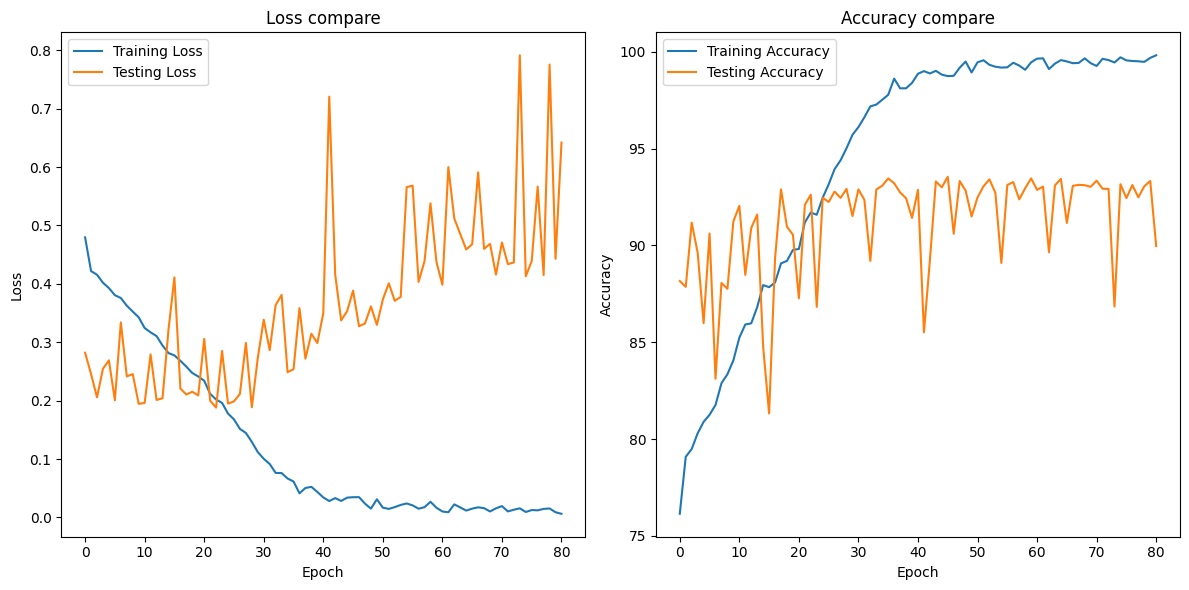

In [35]:
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import MaxNLocator



n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(np.arange(start, start+n_epochs,dtype=int), running_loss_list, label='Training Loss')
ax[0].plot(np.arange(start, start+n_epochs,dtype=int), testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

ax[1].plot(np.arange(start, start+n_epochs,dtype=int), running_accu_list, label='Training Accuracy')
ax[1].plot(np.arange(start, start+n_epochs,dtype=int), testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

plt.tight_layout()

figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
if os.path.isfile(figname):
  print(f"{figname} exist.")
else:
  plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'


#若是從checkpoint跑模型,把loss data接上去,loss data預設在模型參數資料夾下
if os.path.isfile(lossname):
  with open(lossname, 'r') as f:
    data_to_save = json.load(f)
  data_to_save['running_loss_list'].extend(running_loss_list)
  data_to_save['testing_loss_list'].extend(testing_loss_list)
  data_to_save['running_accu_list'].extend(running_accu_list)
  data_to_save['testing_accu_list'].extend(testing_accu_list)
else:
  data_to_save = {
      'running_loss_list': running_loss_list,
      'testing_loss_list': testing_loss_list,
      'running_accu_list': running_accu_list,
      'testing_accu_list': testing_accu_list
  }

with open(lossname, 'w') as f:
    json.dump(data_to_save, f, indent=4)

# 儲存模型參數



In [36]:
print(f'{model_name}_{epoch}')
print(f'{modeldirname}')

unet_without_decoder_81
unet_0.8_testintrain


In [37]:

filename = save_model(model)


params = {
    'num_epochs': epoch,
    'batch_size': batch_size,
    'learning_rate': lr,
    'droprate': droprate
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

model will be saved as /content/drive/MyDrive/AOCR2024/params//
請輸入模型儲存的檔名:unet_without_decoder_80
請輸入模型儲存的資料夾:unet_0.8_testintrain
/content/drive/MyDrive/AOCR2024/params/unet_0.8_testintrain/unet_without_decoder_80.pth exist.


# 讀取模型參數

In [69]:
# model = pretrained_model
model = unet_model
print(model_name)

unet_without_decoder


In [70]:
model = model.to(device)
model ,_ ,params ,_ = load_model(model)

請輸入模型參數檔案名稱:unet_without_decoder_60
請輸入儲存模型的母資料夾名稱:unet_adam_0.9
<All keys matched successfully>


# 單次評估


In [ ]:
# 評估設置
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)


valid_dataset = CustomDataset(images_train, labels_train, transform=transform_standard)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion = nn.BCELoss()
valid_loss, valid_accuracy, predict_list = valid(valid_loader, model, criterion, 0.5, device)

print(f"Accuracy of the network on the test images: {valid_accuracy}%")
print(f"Loss: {valid_loss}")
predict_listq = predict_list.cpu()


Accuracy of the network on the 15592   
training images: 99.20472036942022%  
Loss: 0.03187363331013983


In [ ]:
print_results(predict_listq, labels[:len(predict_listq)])

# 測試

In [71]:
testdir = "Cropped_60-316_150-406_11-71/Test_Image_cropped"

In [55]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, testdir,token = credentials.token))

0it [00:00, ?it/s]


In [35]:
images_test, info = read_test(testdir,termi=200,shift=0)

0: Read test Zx8E3B91ED97D86D1072C6EA9220FD29DAFB96CD6BB8DC6850 finished...
1: Read test Zx2982812805D4A3FA5078DB705FF20793142A1A712F5108B5 finished...
2: Read test ZxD3CB0C4524F67A4D47F1690790F72DB31FECE3ECCB2B6B08 finished...
3: Read test Zx61704E649960C4025BB3AA0B31C1A75C71442BF48DAC3E19 finished...
4: Read test ZxE1BDE57D85B29E6B1FF4B9DB4EE825804A67EF6AAB90BCCE finished...
5: Read test ZxCC42A7155619FA3703EAF742893B8B292D91D0D647A15B0A finished...
6: Read test Zx577646F814CED80AB3D413794C12892EEB3B60D14B6215C6 finished...
7: Read test ZxA1ABBC6166B65AC2A7937A2159F61BA67D2DA16F3ED4D0FB finished...
8: Read test ZxE7E2340E9CF9166BA3E027E0C1D7FC58A90E1BE3552A780A finished...
9: Read test Zx3AB91ED4F2F9AA3B238DDC9EEE0BF3E122BE00BCE2D2CD99 finished...
10: Read test Zx00FE1B9A88E88C71917ECC1EDD774252C072CA5FDB12C01B finished...
11: Read test Zx55393C140B1339C1BC5F7EE2C28DB481D9BC6ECF9EF814ED finished...
12: Read test Zx9C3E8837FD6AE59582C5B3B20ABF573D9A30A6899BB913B4 finished...
13: Read 

In [56]:
len(images_test)

12000

In [73]:
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)


# 對testing dataset做normalization
dataset = CustomDataset(images_test, None, mode='test', transform=transform_standard)
# dataset = CustomDataset(images_test, None, mode='test', transform=None)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


batch_size:128
128


In [74]:
model.eval()

predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    for j, batch_images in enumerate(dataloader):
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()

        # if predicted.dim() == 0:
        #   predicted = predicted.unsqueeze(0)
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()

In [75]:
predict_listq.sum()

tensor(977.)

# 輸出至提交格式

images讀進來是疊在一起的。 需要info紀錄images檔名順序與分割情況

訓練過程不改變資料順序, 所以輸出順序同輸入.   
predict值跟隨images順序, 照著info把每個predict值(label)與檔名(id)對上. 輸出成提交格式

In [76]:
def yes(predict):
  return int(sum(predict) >= 3)



predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
k = 0  #第幾個scan
ii = 0   #每個key輪到第幾個
id, nslice = info[k][0], info[k][1]
for i in range(len(predict_list)):

  if (ii >= nslice):
    #該換下一個scan了
    output[id] = yes(predict_list[i-nslice:i]) #評估方式

    k += 1
    ii = 0
    id, nslice = info[k][0], info[k][1]

  label = predict_list[i]
  output[id+f'_{ii}'] = int(predict_list[i])
  ii += 1

output[id] = yes(predict_list[(i+1)-ii:]) #補上最後一個scan評估
output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key)) #把母label移動到子label前面
filename = input("輸入提交路徑 (empty for submission\submission.csv)")
dfout.to_csv(os.path.join(drive_rootdir,'params','submission',filename)+'.csv', index=False)

輸入提交路徑 (empty for submission\submission.csv)unet_adam_0.9_60


# 讀取提交格式的檔案

In [ ]:
dftest = read_submission('fisrt_80.csv')
# dftest = read_submission('submission.csv')
dflabel = read_label("TrainValid_ground_truth.csv")

In [ ]:
len(dftest)

In [ ]:
import re


# 抓出scan-level data
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = ~dftest.index.str.match(pattern)
scan_guess = np.array(dftest[mask]['label'])
scan_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

mask = ~mask
cut_guess = np.array(dftest[mask]['label'])
cut_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

In [ ]:
ss = 10
print("="*ss + "F1 score on scan level" + "="*ss)
print_results(scan_guess, scan_truth)
print(),print()
print("="*ss + "F1 score on cut level" +"="*ss )
print_results(cut_guess, cut_truth)

# 其他指令
不在工作流
臨時使用

**驗證數據集標準化**

In [ ]:
from torch.utils.data import DataLoader
import torch

def calculate_mean_std(dataset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    # 初始化总和和平方总和变量，以及样本数量
    total_sum = 0.0
    total_sq_sum = 0.0
    total_count = 0

    for data in dataloader:
        images, _ = data  # 假设每个数据是 (image, label) 格式

        # 将图像数据移至CPU并转换为一维
        images = images.view(images.size(0), -1)
        total_sum += images.sum(dim=1).sum(dim=0)
        total_sq_sum += (images ** 2).sum(dim=1).sum(dim=0)
        total_count += images.size(0) * images.size(1)

    # 计算总平均值和标准差
    mean = total_sum / total_count
    std = (total_sq_sum / total_count - mean ** 2) ** 0.5

    return mean, std




In [ ]:
import torch
# 獲取數據
images, labels = process_data2(datadir, termi=100, dropFalse=0)

In [ ]:

# 計算原始圖片mean
original_mean = torch.mean(images)
original_std = torch.std(images)
print(f'Original Mean: {original_mean}')
print(f'Original Std: {original_std}')

# 製作數據集
transform = transforms.Normalize(mean=original_mean, std=original_std)
dataset = CustomDataset(images, labels , transform=transform)
normalized_mean, normalized_std = calculate_mean_std(dataset)


# 输出
print(f'Normalized Mean: {normalized_mean}')
print(f'Normalized Std: {normalized_std}')



# # 計算原始圖片mean
# original_mean = torch.mean(images)
# original_std = torch.std(images)
# print(f'Original Mean: {original_mean}')
# print(f'Original Std: {original_std}')

# # 製作數據集
# transform = transforms.Normalize(mean=original_mean, std=original_std)
# dataset = CustomDataset(images, labels)

# normalized_images, normalized_labels = dataset[:]
# normalized_mean, normalized_std = torch.mean(normalized_images), torch.std(normalized_images)


# print(f'Normalized Mean: {normalized_mean}')
# print(f'Normalized Std: {normalized_std}')


**下載每個checkpoint的參數並validate**

In [ ]:
filelist = os.listdir('/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_SGD_cosannealing')
current_folder = 'tf_efficientnetv2_s_SGD_cosannealing'

In [ ]:
# model = unet_model
model = pretrained_model

model = model.to(device)
print(model_name)

criterion = nn.BCELoss()

tf_efficientnetv2_s


In [ ]:
train_id, valid_id = get_split()
images_valid, labels_valid = process_data2(datadir, dropFalse=0, files=valid_id)
images_validtrain, labels_validtrain =  process_data2(traindir=datadir,dropFalse=0,dropPos=0, files=train_id)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC finished...
Process 1: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4 finished...
Process 2: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA finished...
Process 3: Zx0800DE5C96380322C65ABA398FC93B5CBDF75B20B11DDF6E finished...
Process 4: Zx09972B8FA6215EEC75DB4194B16C000F47B5F87AFB64A12B finished...
Process 5: Zx0A1564C092259CD377329E07006281E876D09F9B48E77002 finished...
Process 6: Zx0AE5424009C101F7422C5BD9DD2C3B0E13E834114A32883A finished...
Process 7: Zx0BA755CD6D068378215FE1AE4751945053ED5D2F2C2A40E7 finished...
Process 8: Zx0CA5CE197AA9378EE23F949BDFC91790D4FED5D6FD06F5A2 finished...
Process 9: Zx0CFB1637BD27964BE741B2AA07BC7C84B2B61731E47782E0 finished...
Process 10: Zx0E094D2402D05592511D0DED9E7ED9E999B468C249E9253F finished...
Process 11: Zx0E96DE51997AF17C5C54835EAD6B7512C66F91BFDB491B9F 

In [ ]:
batch_size = 64
mean_train_, std_train_ = torch.mean(images_validtrain), torch.std(images_validtrain)
transform_train_ = transforms.Normalize(mean=mean_train_, std=std_train_)
validtrain_dataset = CustomDataset(images_validtrain, labels_validtrain, transform=transform_train_)
validtrain_loader = DataLoader(validtrain_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

valid_dataset = CustomDataset(images_valid, labels_valid, mode='valid', transform=transform_train_)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

running_loss_list = []
testing_loss_list = []
running_accu_list = []
testing_accu_list = []

for current_model in filelist[2:]:
  model,_,params,_ = load_model(model, modelname=current_model.rstrip('.pth'),dirname=current_folder)


  epoch_loss, epoch_accuracy, predict_list_validtrain, predict_labels_validtrain  = valid(validtrain_loader, model, criterion, 0.5, device)
  valid_loss, valid_accuracy, predict_list, predict_labels_valid = valid(valid_loader, model, criterion, 0.5, device)

  running_loss_list.append(epoch_loss)
  testing_loss_list.append(valid_loss)
  running_accu_list.append(epoch_accuracy)
  testing_accu_list.append(valid_accuracy)

  predict_listq = predict_list.cpu()
  predict_listq_validtrain = predict_list_validtrain.cpu()

  print(f"Accuracy of the {current_model} on the valid images: {valid_accuracy}%")
  print(f"Loss: {valid_loss}")
  print_results(predict_listq, predict_labels_valid)


  print(f"Accuracy of the {current_model} on the validtrain images: {epoch_accuracy}%")
  print(f"Loss: {epoch_loss}")
  print_results(predict_listq_validtrain, predict_labels_validtrain)

<All keys matched successfully>
Accuracy of the tf_efficientnetv2_s_20.pth on the valid images: 92.99166666666666%
Loss: 0.4579299952527706

      真實值
  預  +-----+-----+
  測| TP: 245| FP: 177|
  值| FN: 664| TN: 10914|
      +-----+-----+ 

recall=0.26952695269526955
precision=0.580568720379147
F1=0.3681442524417732

Accuracy of the tf_efficientnetv2_s_20.pth on the validtrain images: 99.86866244162775%
Loss: 0.003950398122997285

      真實值
  預  +-----+-----+
  測| TP: 224| FP: 3426|
  值| FN: 3365| TN: 40953|
      +-----+-----+ 

recall=0.06241292839230984
precision=0.06136986301369863
F1=0.06188700096698439

<All keys matched successfully>


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import MaxNLocator

savepath = "/content/drive/MyDrive/AOCR2024/params/tf_efficientnetv2_s_cos/tf_efficientnetv2_s_400"
n_epochs = len(running_loss_list)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot( running_loss_list, label='Training Loss')
ax[0].plot( testing_loss_list, label='Testing Loss')
ax[0].set_title('Loss compare')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

ax[1].plot( running_accu_list, label='Training Accuracy')
ax[1].plot( testing_accu_list, label='Testing Accuracy')
ax[1].set_title('Accuracy compare')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # 設置 X 軸只顯示整數

plt.tight_layout()

figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
if os.path.isfile(figname):
  print(f"{figname} exist.")
else:
  plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'


#若是從checkpoint跑模型,把loss data接上去,loss data預設在模型參數資料夾下
if os.path.isfile(lossname):
  with open(lossname, 'r') as f:
    data_to_save = json.load(f)
  data_to_save['running_loss_list'].extend(running_loss_list)
  data_to_save['testing_loss_list'].extend(testing_loss_list)
  data_to_save['running_accu_list'].extend(running_accu_list)
  data_to_save['testing_accu_list'].extend(testing_accu_list)
else:
  data_to_save = {
      'running_loss_list': running_loss_list,
      'testing_loss_list': testing_loss_list,
      'running_accu_list': running_accu_list,
      'testing_accu_list': testing_accu_list
  }

with open(lossname, 'w') as f:
    json.dump(data_to_save, f, indent=4)

drive檔案處理

重命名檔案

In [ ]:
cd /content/drive/MyDrive/AOCR2024/params

In [ ]:
# %shell for file in tf_efficientnetv2_m*; do mv "$file" "${file/tf_efficientnetv2_m/unet}"; done

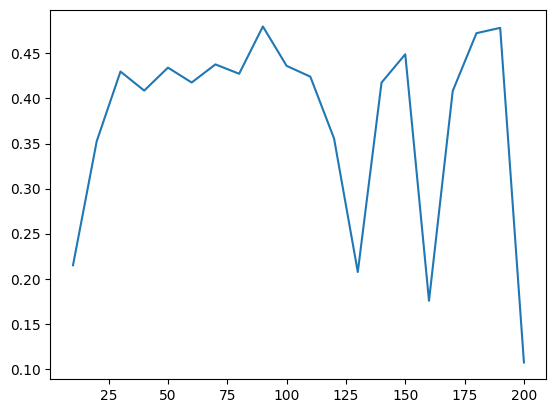

In [47]:
import matplotlib.pyplot as plt

x = range(10,210,10)
y = [0.21497405485544846,0.3526900085397096,0.42987249544626593,0.408731241473397,0.43421052631578944,0.41770102536427417,0.43779342723004694,0.42740414833438095,0.47986434930055116,0.4362030905077262,0.4241719930273096,0.3555230431602049,0.20746132848043677,0.4176013805004314,0.4490445859872611,0.17557251908396945,0.40830945558739257,0.472430224642614,0.47833775419982316,0.1071060762100927]
plt.plot(x,y)